<h2>Deterministic Policies</h2>

In [ ]:
'''
pi_net = nn.Sequential(
        nn.Linear(obs_dim, 64),
        nn.Tanh(),
        nn.Linear(64, 64),
        nn.Tanh(),
        nn.Linear(64, act_dim)
        )
'''

<h2>Stochastic Policies</h2>

#### Categorical policies -> Discrete action spaces

#### Diagonal Gaussian policies -> Continuous action spaces

## Value Function

#### On-Policy Value Function
 - expected return starting from state s, acting by policy

#### On-Policy Action-Value Function
 - expected return starting from state s, taking arbitrary action a
 
#### Optimal Value Function
 - expected return starting from state s, always acting optimal policy

#### Optimal Action-Value Function
 - expected return starting from state s, taking arbitrary action a, acting optimal policy
 



### Bellman Equation 
 - The value of your starting point 
     = reward expecting to get from being there + value of next state


<h2>Kinds of RL Algorithms</h2>


#### Model-Free vs Model-Based
 - whether the agent has access to (or learns) a model of the environment
 
1. Policies (stochastic / deterministic)
2. Action-Value Functions (Q-Functions)
3. Value Functions
4. and/or environments models




### Model-Free

#### Policy Optimization
 1. directly by gradient ascent (on-policy)
 2. indirectly by maximizing local approximations (on-policy)
  - On-Policy : each update only uses only collected while actiong according to the most recent version of the policy
  - directly optimize : stable, reliable


#### Q-Learning
 - Off-Policy : each updates can use data collected at any point during training
 - DQN
 - indirectly optimize : many failure modes, self-consistency equation, more efficient(reuse data)


### Model-Based
 
#### Pure Planning
 - use model-predictive control (MPC) to select actions
 - calculates the plan whenever agent observes environments -> agent executes the first action of the plan, immediately discards the rest of it.
 - computes a new plan each time it prepares to interact with the environment
 
#### Expert Iteration
 - using and learning an explicit representation of the policy
 - uses planning algorithm (Monte Carlo Tree Search)
      - produces an action which is better than what the policy alone would have produce


## Policy Gradient

#### Why?
 - policy is fixed in Q-Learning -> stochastic policy learning X -> epsilon-greedy exploration (inefficient)
 - easy to control continuous actions
 
 - RL Goal: finds optimal behavior strategy to get optimal reward
 - directly optimizes the policy

### Simple Policy Gradient

In [ ]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import numpy as np
import gym
from gym.spaces import Discrete, Box

def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

def train(env_name='CartPole-v0', hidden_sizes=[32], lr=1e-2, 
          epochs=50, batch_size=5000, render=False):

    # make environment, check spaces, get obs / act dims
    env = gym.make(env_name)
    assert isinstance(env.observation_space, Box), \
        "This example only works for envs with continuous state spaces."
    assert isinstance(env.action_space, Discrete), \
        "This example only works for envs with discrete action spaces."

    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n

    # make core of policy network
    logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts])

    # make function to compute action distribution
    def get_policy(obs):
        logits = logits_net(obs)
        return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
        return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    # this loss function doesn't measure performance
    def compute_loss(obs, act, weights):
        logp = get_policy(obs).log_prob(act)
        return -(logp * weights).mean()

    # make optimizer
    optimizer = Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rewards = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False

        # collect experience by acting in the environment with current policy
        while True:

            # rendering
            if (not finished_rendering_this_epoch) and render:
                env.render()

            # save obs
            batch_obs.append(obs.copy())

            # act in the environment
            act = get_action(torch.as_tensor(obs, dtype=torch.float32))
            obs, reward, done, _ = env.step(act)

            # save action, reward
            batch_acts.append(act)
            ep_rewards.append(reward)

            if done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rewards), len(ep_rewards)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)

                # the weight for each logprob(a|s) is R(tau)
                batch_weights += [ep_ret] * ep_len

                # reset episode-specific variables
                obs, done, ep_rewards = env.reset(), False, []

                # won't render again this epoch
                finished_rendering_this_epoch = True

                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
                                  act=torch.as_tensor(batch_acts, dtype=torch.int32),
                                  weights=torch.as_tensor(batch_weights, dtype=torch.float32)
                                  )
        batch_loss.backward()
        optimizer.step()
        return batch_loss, batch_rets, batch_lens

    # training loop
    for i in range(epochs):
        batch_loss, batch_rets, batch_lens = train_one_epoch()
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (i, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))
        
if __name__ == '__main__':
    import argparse
    parser = argparse.ArgumentParser()
    parser.add_argument('--env_name', '--env', type=str, default='CartPole-v0')
    parser.add_argument('--render', action='store_true')
    parser.add_argument('--lr', type=float, default=1e-2)
    args = parser.parse_args()
    print('\nUsing simplest formulation of policy gradient.\n')
    train(env_name=args.env_name, render=args.render, lr=args.lr)

In [4]:
import sys
sys.path.append('/home/dnclab/env/mi333/lib/python3.8/site-packages')

/home/dnclab/env/mi333/lib/python3.8/site-packages/gym/envs/registration.py:595: UserWarning: WARN: Overriding environment FrozenLake-v3
  logger.warn(f"Overriding environment {id}")


Success rate: 0.97
Final Q-Table Values
LEFT DOWN RIGHT UP
[[0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]


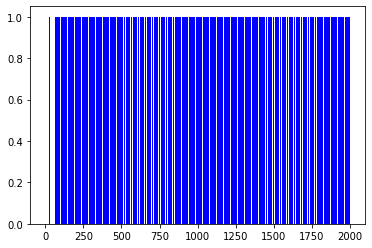

In [6]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as pr

def rargmax(vector):
    m = np.amax(vector)
    indices = np.nonzero(vector == m)[0]
    return pr.choice(indices)

register(
    id='FrozenLake-v3',
    entry_point='gym.envs.toy_text:FrozenLakeEnv',
    kwargs={'map_name': '4x4',
            'is_slippery': False}
)
env = gym.make('FrozenLake-v3')

Q = np.zeros([env.observation_space.n, env.action_space.n])

num_episodes = 2000

rList = []
for i in range(num_episodes):
    state=env.reset()
    rAll = 0
    done = False

    # Q-Learning Algorithm
    while not done:
        action = rargmax(Q[state, :])

        new_state, reward, done, _ = env.step(action)

        Q[state, action] = reward + np.max(Q[new_state,:])

        rAll += reward
        state = new_state
    rList.append(rAll)

print("Success rate: "+str(sum(rList)/num_episodes))
print("Final Q-Table Values")
print("LEFT DOWN RIGHT UP")
print(Q)
plt.bar(range(len(rList)), rList, color="blue")
plt.show()
